In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px

%matplotlib inline

In [2]:
# Отгрузил дату

ads = pd.read_csv('ads_data.csv')
ads_clients = pd.read_csv('ads_clients_data.csv')

# The first task


In [3]:
# Разберусь с  распределением количества показов и кликов. 
# Посчитаю среднее количество показов и среднее количество кликов 
# на объявления за весь период.

In [4]:
ads.head(2)

,date,time,event,platform,ad_id,client_union_id,campaign_union_id,ad_cost_type,ad_cost,has_video,target_audience_count
0,2019-04-01,2019-04-01 00:00:48,view,android,45061,34734,45061,CPM,200.6,0,1955269
1,2019-04-01,2019-04-01 00:00:48,view,web,121288,121288,121288,CPM,187.4,0,232011


In [5]:
pivot_per_ad_events = number_per_ad_per_event = ads.groupby(['ad_id', 'event'], as_index=False) \
    .agg({'time': 'count'}) \
    .rename(columns={'time': 'event_number'})
# Предобработали данные

In [6]:
pivot_per_ad_events = number_per_ad_per_event.pivot(index='ad_id', columns='event', values='event_number').fillna(0)
# Создали сводную таблицу, для удобства работы, пустые значения заполнили нулями.

In [7]:
pivot_per_ad_events.mean().round() # Cреднее количество показов и среднее количество кликов.

event
click    113.0
view     923.0
dtype: float64

# The second task

In [9]:
# Теперь я хочу посчитать скользящее среднее показов с окном 2.

# Далее узнаю значение скользящего среднего за 6 апреля 2019 года.

# Здесь необходимо 2 раза рассчитать среднее
# Первое среднее считается по числу показанных реклам для каждого дня, 
# а 2-ое с применением rolling.

In [11]:
ads_view_per_date = ads.query('event == "view"') \
    .pivot_table(index='ad_id', columns='date', values='time', aggfunc='count')

# Отсортировали столбец "event" по view.
# Создали сводную таблицу, чтобы было легче работать с данными.

In [12]:
mean_views = ads_view_per_date.mean() # Посчитали среднее по просмотрам.

In [13]:
rolling_views = mean_views.rolling(2).mean() # Посчитали среднее по просмотром, с rolling(2).

In [14]:
rolling_views['2019-04-06'] # Среднее значение за 6 апреля 2019 года 

598.1162023460411

# The third task

In [15]:
# Скользящее среднее часто используется для поиска аномалий в данных.
# Попробую нанести на один график значения арифметического 
# среднего по дням и скользящего среднего количества показов. В какой 
# день наблюдается наибольшая разница по модулю между арифметическим 
# средним и скользящим средним? Дни, в которых скользящее среднее равно 
# NaN, учитывать не буду. 

In [16]:
sns.set(
    font_scale=2,
    style='whitegrid',
    rc = {'figure.figsize': (20, 7)}
)
# Делаю график более понятным.

<Axes: xlabel='date'>

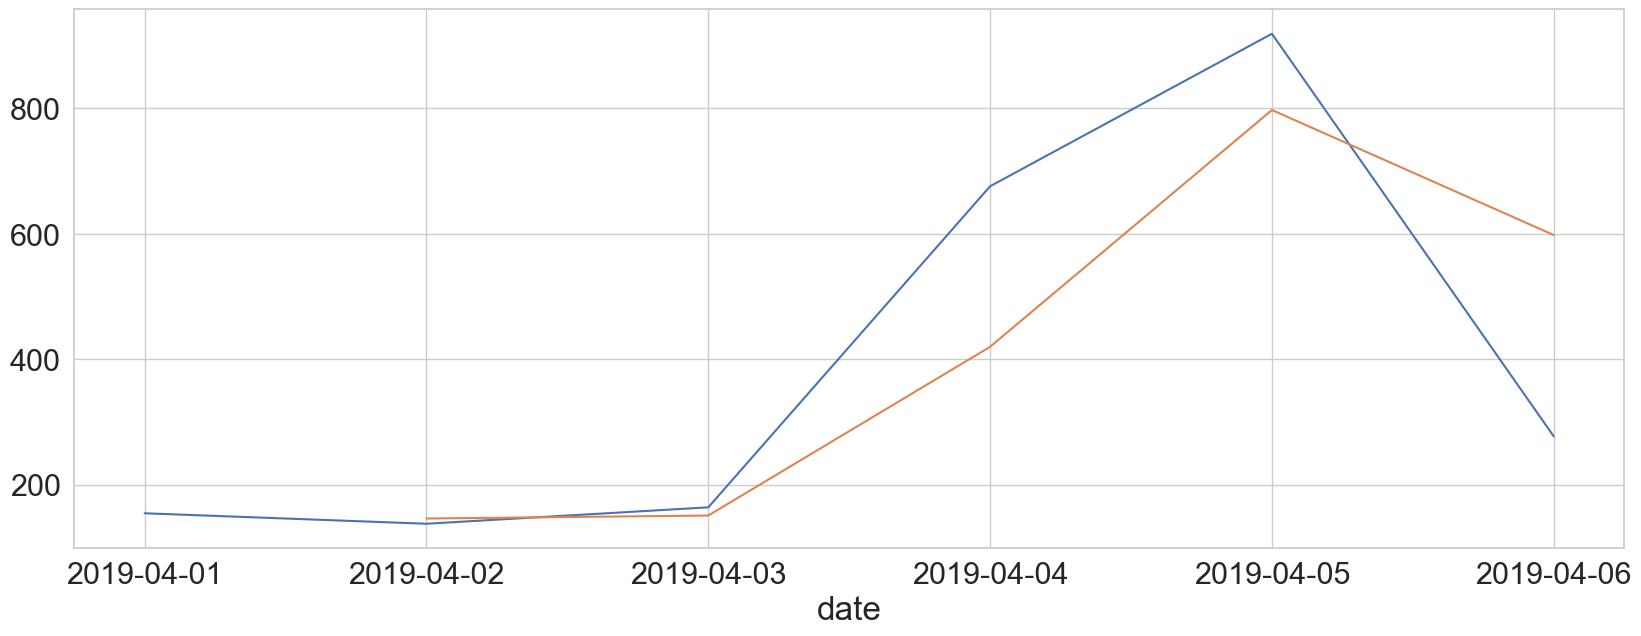

In [17]:
sns.lineplot(data=mean_views)
sns.lineplot(data=rolling_views)

In [18]:
# Нашел индекс анамальной даты
anomaly_date = mean_views.subtract(rolling_views) \
          .abs() \
          .idxmax() 

# The fourth task

In [19]:
# Напишу функцию, которая найдет проблемное объявление 
# с наибольшим/наименишим количеством показов в день, 
# в который была замечена самая большая по модулю аномалия. 

In [20]:
# Берем разницу между средним и скользящем скредним.
difference_value = mean_views.subtract(rolling_views)[anomaly_date]

# Если число отрицательное или ноль, то берем индекс максимального числа
if difference_value <= 0:
    anomaly_ad = ads_view_per_date[anomaly_date].idxmax()

# Иначе берем индекс минимального числа
else:
    anomaly_ad = ads_view_per_date[anomaly_date].idxmin()

    
    

In [21]:
anomaly_ad

112583

In [22]:
# Нашел максимум по колонке
ads_view_per_date.loc[[112583]]

date,2019-04-01,2019-04-02,2019-04-03,2019-04-04,2019-04-05,2019-04-06
ad_id,,,,,,
112583,NaN,NaN,NaN,NaN,302811.0,48991.0


In [23]:
def find_anomaly_date(ad_view_per_day_per_add):
    # Для каждой даты считаем среднее
    mean_views = ad_view_per_day_per_add.mean()
    
    # Ищем аномальный день
    mean_difference = mean_views.subtract(rolling_views)
    anomaly_date = mean_views.subtract(rolling_views) \
          .abs() \
          .idxmax() \
    
    # Берем разницу между средним и скользящем скредним.
    difference_value = mean_difference[anomaly_date]

    # Если число отрицательное или ноль, то берем индекс максимального числа
    if difference_value <= 0:
        anomaly_ad = ad_view_per_day_per_add[anomaly_date].idxmax()

    # Иначе берем индекс минимального числа
    else:
        anomaly_ad = ad_view_per_day_per_add[anomaly_date].idxmin()
        
    return anomaly_ad